This is a Poisson equation with Dirichlet and Periodic initial conditions solved with a PINN model using the DeepXDE library.

<br>

\begin{equation}
-Δu = π^2sin(πx) \hspace{1cm} x∈[−1,1]
\end{equation}

<br>

\begin{equation}
u'(-1) = 0 \hspace{1cm} u(1) = u(0)
\end{equation}

Test losses after 8000 epochs are approximately:

*In accordance to y output:* **6.21e-03**

*In accordance to initial conditions:* **1.72e-03**, **4.51e-03**

*In accordance to the known solution:* **3.41e-02**

In [ ]:
# Import libraries

!pip install deepxde
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [ ]:
# Define computational geometry

geom = dde.geometry.Interval(-1,1)

In [ ]:
# Define differential equation

def ode(x,y):
  du_xx = dde.grad.hessian(y,x)
  return du_xx + np.pi**2 * tf.sin(np.pi*x)

In [ ]:
# Define initial conditions

def ic_dirichlet(x,_):
  return np.isclose(x[0], -1)

def ic_periodic(x,_):
  return np.isclose(x[0], 1)

ic1 = dde.icbc.DirichletBC(geom, lambda x: 0, ic_dirichlet)
ic2 = dde.icbc.PeriodicBC(geom, 0, ic_periodic)

In [ ]:
# Define known solution

def sol(x):
  return np.sin(np.pi*x)

In [ ]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, ode, [ic1,ic2], num_domain = 1000, num_boundary = 10, solution = sol, num_test = 100)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1002=1002. 
  total_n_samples))


In [ ]:
# Create the neural network

layer_size = [1] + [60]*3 +[1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
# Build and train the model

model = dde.Model(data, net)
model.compile("adam", lr = 0.01, metrics = ["l2 relative error"])

losshistory, train_state = model.train(epochs = 8000)

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'build' took 0.256565 s

'compile' took 0.965890 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.86e+01, 1.65e-03, 6.59e-03]    [4.94e+01, 1.65e-03, 6.59e-03]    [1.03e+00]    
1000      [3.03e-02, 4.15e-06, 7.11e-04]    [2.84e-02, 4.15e-06, 7.11e-04]    [1.85e-02]    
2000      [2.81e-02, 5.22e-03, 2.13e-02]    [2.43e-02, 5.22e-03, 2.13e-02]    [6.67e-02]    
3000      [1.56e-02, 6.17e-04, 1.78e-03]    [1.57e-02, 6.17e-04, 1.78e-03]    [3.22e-02]    
4000      [4.24e-02, 3.17e-04, 9.37e-05]    [4.29e-02, 3.17e-04, 9.37e-05]    [2.46e-02]    
5000      [2.24e-03, 2.90e-04, 1.25e-03]    [1.94e-03, 2.90e-04, 1.25e-03]    [1.54e-02]    
6000      [2.38e-03, 3.27e-04, 1.39e-03]    [2.30e-03, 3.27e-04, 1.39e-03]    [1.63e-02]    
7000      [7.16e-04, 1.86e-04, 7.42e-04]    [7.14e-04, 1.86e-04, 7.42e-04]    [1.52e-02]    
8000      [6.85e-03, 1.72e-03, 4.51e-03]    [6.21e-03, 1.72e-03, 4

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


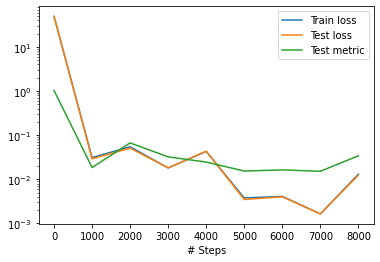

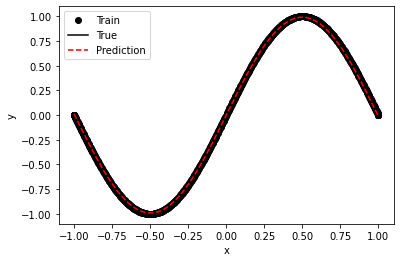

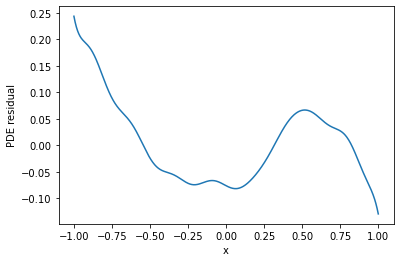

In [ ]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=ode)

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()